In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd

In this report, we aim at solving numerically a 1D elliptic SPDE, and then estimate the expectation of flow flux by Multilevel MonteCarlo.

We will also try to generalize to more complicated case where the right hand side is non-zero

# 1D SPDE

$\frac{d}{dx}\left(\kappa\frac{dp}{dx}\right) = 0$

on $x\in[0,1]$, $p(0) = 0, p(1) = 1$

Output of interest: $\int_0^1\kappa\frac{dp}{dx}dx$

$Z(x) = \log\kappa(x)$ is Gaussian, covariance $C(x, y) = \mathbb{E}[u(x)u(y)] = \exp(-|x-y|)$

The problem will consists of 2 parts: 

- 1. Sampling of random coefficients $\kappa(x, \omega)$;
- 2. Given a random sample $\omega$, Solving numerically the elliptic equation with coefficient $\kappa(x, \omega)$

## 0. Spatial discretisation on 1D 

We take $M$ equally spaced points on interval $[0, 1]$ to discretise the space.

Let $x^{(l)}_i = \frac{i}{M_l}, i = 0, 1, ..., M_l$ be partition at level $l$

In [2]:
M = 20
interval_example = np.linspace(0, 1, M)

## 1. Sampling of random coefficients $\kappa(x, \omega)$

### Method mentioned in paper [1]

Karhunen-Loève expansion: let $Z(x,\omega) = \log\kappa(x, \omega)$, then $Z(x, \omega)$ can be expanded by countable set of uncorrelated zero mean randomn variables $\{\xi_n\}_{n\in\mathbb{N}}$:

$
Z(x, \omega) = \mathbb{E}[Z(x, .)] + \sum\limits_{n=1}^\infty\sqrt{\theta_n}\xi_n(\omega)b_n(x)
$

$\theta_n$ and $b_n$ are eigenvalues and eigenfunctions of $C(x, y)$

$
\int C(x, y)b_n(y)dy = \theta_nb_n(x)
$

When $Z$ is Gaussian, $\{\xi_n\}$ are a set of independent standard Gaussian variables

Assume $C(x, y) = \exp(-|x-y|/\lambda)$

For the case of our problem ($\lambda=1$), we have the following expressions for $\theta_n$ and $b_n$

$\theta_n = \frac{2\lambda}{\lambda^2\omega_n^2 + 1}$

$b_n(x) = A_n(\sin(\omega_nx) + \lambda\omega_n\cos(\omega_nx))$

$\{\omega_n\}$ are real solutions of the equation $\tan(\omega) = \frac{2\lambda\omega}{\lambda^2\omega^2-1}$

### Cholesky factorisation applied on discrete scheme

In our case, we use Cholesky factorisation to generate samples of $Z(x)$ on discrete points

$x^{(l)}_i = \frac{i}{M_l}, i = 0, 1, ..., M_l$

For simplicity, we use directly np.random.multivariate_normal

In [3]:
lambd = 1
correlation = lambda x, y: np.exp(-np.abs(x - y)/lambd)

def generateCorrelationForScheme(scheme, correl_func = correlation):
    '''scheme: a discretised interval with M points from 0 to 1
       correl_func: correlation function 
    '''
    M = len(scheme)
    matrix = np.array([correl_func(scheme[i], scheme[j]) for i in range(M) for j in range(M)]).reshape(-1, M)
    return matrix

Example

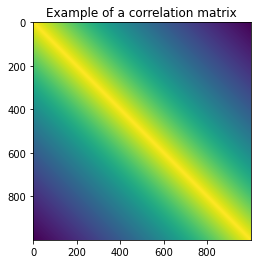

In [4]:
M_l = 1000
scheme_l = np.linspace(0, 1, M_l)
correl_l = generateCorrelationForScheme(scheme_l)

plt.imshow(correl_l)
plt.title('Example of a correlation matrix')

N_l = 100

z_sample = np.random.multivariate_normal(np.zeros(M_l), correl_l, size = N_l)

kappa = np.exp(z_sample)

In [5]:
def generateCoefficientKappa(Nl, Ml):
    '''Nl: Number of samples;
       Ml: Number of discretisation
    '''
    scheme = np.linspace(0, 1, Ml)
    correl = generateCorrelationForScheme(scheme)
    z_sample = np.random.multivariate_normal(np.zeros(Ml), correl, size = Nl)
    return np.exp(z_sample)

## 2. Numerical solution of PDE

### 2.1 Finite volume method

We use finite volume discretisation, and take $\kappa(x)$ and $p(x)$ as piecewise constant on $[0, 1]$. On interval $[(i-1)/M, i/M]$, we have

$\kappa(x) = \kappa^{(M)}_i, p(x) = p^{(M)}_i, i=1,...,n$

On interval $[(i-1)/M, i/M]$, we integrate the equation and obtain by divergence theorem (Lebesgue integral formula on 1D):

$\kappa(\frac{i}{M})\frac{dp}{dx}(\frac{i}{M}) - \kappa(\frac{i-1}{M})\frac{dp}{dx}(\frac{i-1}{M})= 0$

We then approximate $\kappa(i/M)\approx \frac{1}{2} (\kappa^{(M)}_i + \kappa_i^{(M)})$, and approximate $\frac{dp}{dx}(\frac{i}{M})\approx \frac{p_{i+1}^{(M)} - p_i^{(M)}}{\frac{1}{M}}$

Also keep in mind the boundary condition, we assume $p_1^{(M)} = 0, p_M^{(M)} = 1$

Then we can write $M-2$ equations

$(\kappa^{(m)}_{i+1} + \kappa_i^{(m)})p_{i+1}^{(m)}- (\kappa^{(m)}_{i+1} + 2\kappa^{(m)}_{i} + \kappa_{i-1}^{(m)})p_i^{(m)} + (\kappa^{(m)}_{i} + \kappa_{i-1}^{(m)})p_{i-1}^{(m)} = 0$

Solving this linear system, we will obtain the value of $p$ on small volumes of interval.

$A(K)P = F(K)$, $P = (p_2, ..., p_{m-1})$

$A(K)=\left(
  \begin{array}{cccccc}
    -(\kappa_3 + 2\kappa_2 + \kappa_1) & (\kappa_2 + \kappa_3) & 0 & ... & 0& 0\\
    \kappa_2 + \kappa_3 & -(\kappa_4 + 2\kappa_3 + \kappa_2) & \kappa_3 + \kappa_4 & ... & ... & 0 \\
    0 & \kappa_3 + \kappa_4& -(\kappa_5 + 2\kappa_4 + \kappa_3) & \kappa_4 + \kappa_5 & ... & 0 \\
    ...& ... & ... & ... & ... & ... \\
    0 & ... & ... & \kappa_{M-2} + \kappa_{M-3}& -(\kappa_{M-1} + 2\kappa_{M-2} + \kappa_{M-3}) & \kappa_{M-1} + \kappa_{M-2}  \\
    0 & ... & ... & 0 &\kappa_{M-1} + \kappa_{M-2} & -(\kappa_M + 2\kappa_{M-1} + \kappa_{M-2}) \\
  \end{array}
\right)$

$A(K)$ is a ${(M-2)\times(M-2)}$ matrix

$F(K) = (0, ..., 0, -(\kappa_{M-1} + \kappa_{M}))\in\mathbb{R}^{M-2}$

In [6]:
def constructEquationsFromKappa(kappa):
    '''kappa: 1D array, consisting of M values on discretized intervals. M >=3 '''
    M = len(kappa)
    coef = np.zeros((M-2, M-2))
    coef[0][0:2]  = [-(kappa[2]+ 2 * kappa[1] + kappa[0]), kappa[1] + kappa[2]]
    coef[-1][-2:] = [kappa[M-2] + kappa[M-1], -(kappa[M-1] + 2 * kappa[M-2] + kappa[M-3])]
    for i in np.arange(1, M-3, 1):
        coef[i][(i-1):(i+2)] = [kappa[i] + kappa[i+1], -(kappa[i+2] + 2 * kappa[i+1] + kappa[i]), kappa[i+1] + kappa[i+2]]
    
    rhs = np.zeros(M-2)
    rhs[-1] = -(kappa[M-2] + kappa[M-1])
    return coef, rhs

def solveLinearEquation(kappa):
    coef, rhs = constructEquationsFromKappa(kappa)
    
    solv = np.linalg.inv(coef).dot(rhs)
    solution = np.array([0] + list(solv) + [1])
    return solution

Text(0.5, 1.0, 'Example solutions of different random sample for coefficient kappa')

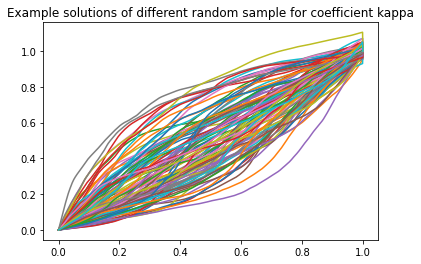

In [7]:
for i in range(len(kappa)):
    coef, rhs = constructEquationsFromKappa(kappa[i])
    sol       = solveLinearEquation(kappa[i])
    plt.plot(np.linspace(0, 1, len(sol)), sol)
plt.title('Example solutions of different random sample for coefficient kappa')

### 2.2 Finite element method

Omitted, we use finite volume only, as finite element involves exra basis functions. The essential of finite volume and finite element methods are both solving a system of linear equations, while finite volume solves the function values on each discretized interval, and finite element solves the coefficients of basis functions.

Given a sample of $\kappa(., \omega)$, now that we have solved the values $p(x)$ on discretised interval, we can calculate quantity of interest. $E(\int_0^1\kappa\frac{dp}{dx}dx)$. We still use the same discretisation scheme of mesh size $1/M$

In [8]:
def computeQoIOneSample(kappa):
    M = len(kappa)
    solution = solveLinearEquation(kappa)
    
    ints = np.array([(kappa[-i] + kappa[-i-1])/2 * (solution[-i] - solution[-i-1]) for i in np.arange(2, M, 1)])   
    return (ints).sum()

## 3. MLMC solution

### 3.1 Standard MonteCarlo

In [9]:
N_samples = [50, 100, 200, 300, 500, 1000, 2000, 5000, 10000]
M = 256

qoi_means = []
qoi_stds  = []

for N_sample in N_samples:
    kappas = generateCoefficientKappa(N_sample, M)
    qoi_MC = np.array([computeQoIOneSample(x) for x in kappas])
    qoi_means.append(qoi_MC.mean())
    qoi_stds.append(qoi_MC.std())

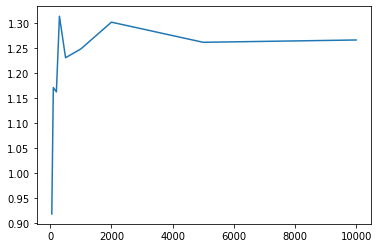

In [10]:
plt.plot(N_samples, qoi_means)

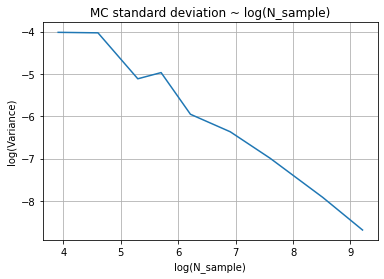

In [11]:
plt.plot(np.log(N_samples), 2 * np.log(qoi_stds/np.sqrt(N_samples)))
plt.title('MC standard deviation ~ log(N_sample)')
plt.xlabel('log(N_sample)')
plt.ylabel('log(Variance)')
plt.grid()

### 3.2 Multilevel MonteCarlo

Take different discretisation size as different levels, we seek the following multilevel estimate:

$
\hat{Q}^{MLMC} = \sum\limits_{l = 0}^L(\hat{Y}_l)
$

Where $\hat{Y}_l = \frac{1}{N_l}\sum\limits_{i=1}^{N_l}(Q^{(i)}_{M_l} - Q^{(i)}_{M_{l-1}})$

In [12]:
L = 8

sum1 = 0

M_0     = 2**4
N_0     = int(10**5/M_0)
kappa_0 = generateCoefficientKappa(N_0, M_0)
qoi_0   = np.array([computeQoIOneSample(x) for x in kappa_0])
sum1    = qoi_0.mean()

means_diff = []
varis_diff = []

means_level = []
varis_level = []

for l in np.arange(4, L + 1, 1):
    M_coarse = 2**l
    M_fine   = 2**(l+1)
    N_l      = int(10**5/M_coarse)

    kappa_fine   = generateCoefficientKappa(N_l ,M_fine)
    kappa_coarse = kappa_fine[:, ::2]

    qoi_coarse = np.array([computeQoIOneSample(x) for x in kappa_coarse])
    qoi_fine   = np.array([computeQoIOneSample(x) for x in kappa_fine])
    
    diff = qoi_fine - qoi_coarse
    
    sum1 = sum1 + (diff).mean()
    
    means_level.append(qoi_coarse.mean())
    varis_level.append(qoi_coarse.var())
    
    means_diff.append(diff.mean())
    varis_diff.append(diff.var())    

Estimated Value from MLMC:

In [13]:
sum1

1.2584204733444542

#### 3.2.1 Mean/Variance plots with levels

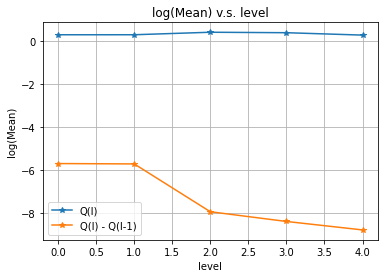

In [14]:
summary_mean = pd.DataFrame([means_level, means_diff]).T.abs().apply(np.log2)
summary_mean.columns = ['Q(l)', 'Q(l) - Q(l-1)']
summary_mean.plot(style = '*-')
plt.xlabel('level')
plt.ylabel('log(Mean)')
plt.title('log(Mean) v.s. level')
plt.grid()

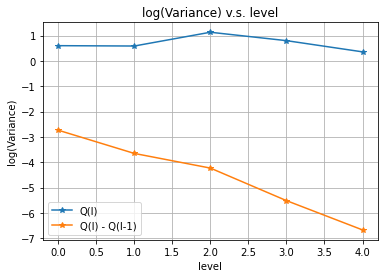

In [15]:
summary_var = pd.DataFrame([varis_level, varis_diff]).T.abs().apply(np.log2)
summary_var.columns = ['Q(l)', 'Q(l) - Q(l-1)']
summary_var.plot(style = '*-')
plt.xlabel('level')
plt.ylabel('log(Variance)')
plt.title('log(Variance) v.s. level')
plt.grid()

#### 3.2.2 Accuracy analysis

In [16]:
def runMLMC(L, L0 = 4, M = 1e5):
    sum1 = 0

    M_0     = 2**L0
    N_0     = int(M/M_0)
    kappa_0 = generateCoefficientKappa(N_0, M_0)
    qoi_0   = np.array([computeQoIOneSample(x) for x in kappa_0])
    sum1    = qoi_0.mean()

    means_diff = []
    varis_diff = []

    means_level = []
    varis_level = []

    for l in np.arange(4, L + 1, 1):
        M_coarse = 2**l
        M_fine   = 2**(l+1)
        N_l      = int(M/M_coarse)

        kappa_fine   = generateCoefficientKappa(N_l ,M_fine)
        kappa_coarse = kappa_fine[:, ::2]

        qoi_coarse = np.array([computeQoIOneSample(x) for x in kappa_coarse])
        qoi_fine   = np.array([computeQoIOneSample(x) for x in kappa_fine])

        diff = qoi_fine - qoi_coarse

        sum1 = sum1 + (diff).mean()

        means_level.append(qoi_coarse.mean())
        varis_level.append(qoi_coarse.var())

        means_diff.append(diff.mean())
        varis_diff.append(diff.var())    
    return sum1

In [19]:
%%time

collect_mlmc = []

for i in range(100):
    collect_mlmc.append(runMLMC(L = 8))

CPU times: user 2h 14min 10s, sys: 19min 30s, total: 2h 33min 40s
Wall time: 40min 57s


Standard deviation of MLMC estimator

In [22]:
np.std(collect_mlmc)

0.017960119467031313

## 4. Summary

MLMC is more efficient than standard MC in solving random coefficient elliptic SPDE. From 3.2.2, we have seen that the standard deviation by MLMC estimator is largely reduced compared to standard MC.

## Reference

Cliffe, K.A., Giles, M.B., Scheichl, R. et al. Multilevel Monte Carlo methods and applications to elliptic PDEs with random coefficients. Comput. Visual Sci. 14, 3 (2011). https://doi.org/10.1007/s00791-011-0160-x